In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
import LPR

In [77]:
def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [78]:
idx = 7
lpr = LPR.LPR()

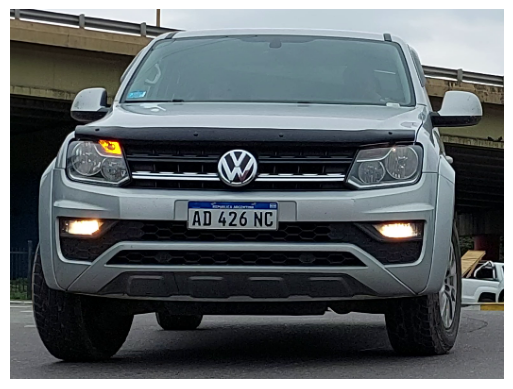

In [291]:
img = cv2.imread(f"./imgs/013.png")
plot_image(img, False)

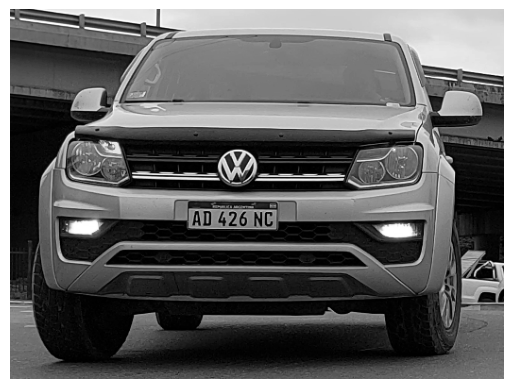

In [292]:
gray = lpr.grayscale(img)
plot_image(gray)

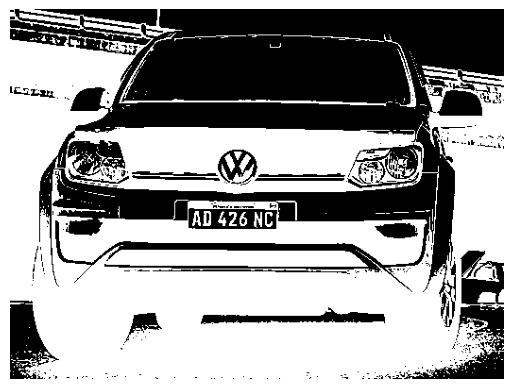

In [293]:
thresh = lpr.apply_threshold(gray)
plot_image(thresh)

In [266]:
'''# Creamos un kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Aplicamos el kernel para juntar los pixeles dispersos
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(thresh,cmap='gray')'''

"# Creamos un kernel\nkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))\n\n# Aplicamos el kernel para juntar los pixeles dispersos\nthresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)\nplt.imshow(thresh,cmap='gray')"

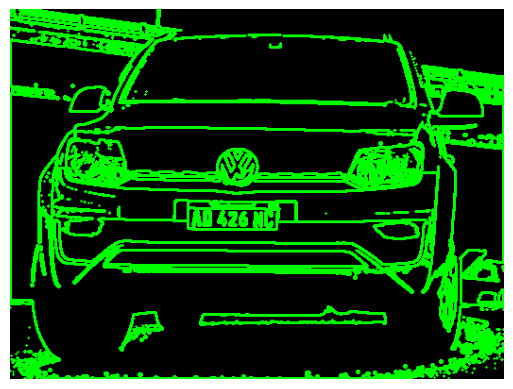

In [294]:
contours = lpr.find_contours(thresh)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

## UMBRALIZACION ADAPTATIVA Y CONTORNOS (No deberia ser necesario)

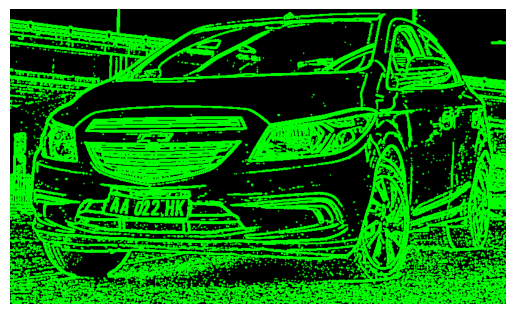

In [287]:
# Ejemplo de umbralización adaptativa
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 7)

contours = lpr.find_contours(adaptive_thresh)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

## DETERMINACION DE AREAS

Area =  1764.0
Area =  2056.5
Area =  1042.5
Area =  1443.0
Area =  1644.0
Area =  1095.5


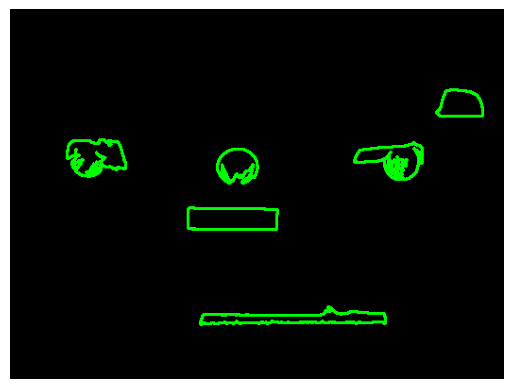

In [295]:
img_output = np.zeros_like(canvas)

for cnt in contours:
    area = cv2.contourArea(cnt)

    # Verifica si el polígono tiene cuatro esquinas (es aproximadamente rectangular)
    if 1000<area<5500:
        print("Area = ",area)
        cv2.drawContours(img_output, [cnt], 0, (0, 255, 0), 2)

plt.axis('off')
plt.imshow(img_output);

## FILTRAR CONTORNOS BASADOS EN EL AREA

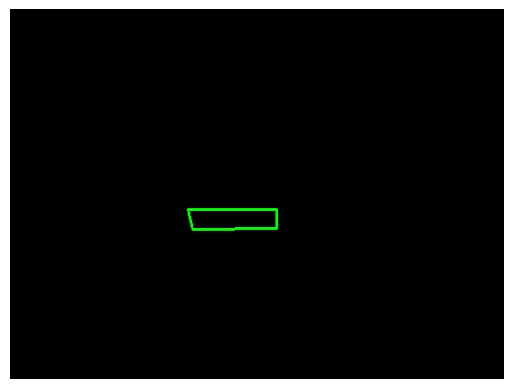

In [296]:
# Filtra contornos basados en área
contours = [cnt for cnt in contours if 1000 < cv2.contourArea(cnt) < 5500]

# Inicializa una lista para almacenar los contornos rectangulares aproximados
rectangular_contours = []

for cnt in contours:
    # Aproxima el contorno a un polígono
    epsilon = 0.03 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # Verifica si el polígono tiene cuatro esquinas (es aproximadamente rectangular)
    if len(approx) == 4:
        rectangular_contours.append(approx)

# Dibuja los contornos rectangulares en una imagen de salida
img_output = np.zeros_like(canvas)
cv2.drawContours(img_output, rectangular_contours, -1, (0, 255, 0), 2)

#print(contours)

plt.axis('off')
plt.imshow(img_output);

In [297]:
#Lo usamos para sacar el alto y ancho de la patente

index = 0 
for cnt in rectangular_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    print('Contorno ', index, 'Ancho:', w, 'Alto:', h)
    index += 1
    

Contorno  0 Ancho: 95 Alto: 22


## FILTRAMOS AREA JUNTO CON EL ANCHO Y EL ALTO DE LA PATENTE

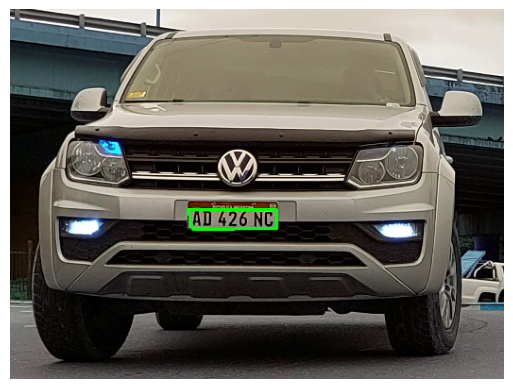

In [298]:
# Filtra contornos basados en área 
contours = [cnt for cnt in contours if 1000 < cv2.contourArea(cnt) < 5500]

# Inicializa una lista para almacenar los contornos rectangulares aproximados
rectangular_contours = []

for cnt in contours:
    # Aproxima el contorno a un polígono
    epsilon = 0.03 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    x, y, w, h = cv2.boundingRect(cnt)

    # Verifica si el polígono tiene cuatro esquinas (es aproximadamente rectangular)
    # Tambien se verifica el ancho (with)
    if len(approx) == 4 and (69 <= w <= 130) and (16 <= h <= 50):
        rectangular_contours.append(approx)

# Dibuja los contornos rectangulares en una imagen de salida
img_output = np.zeros_like(canvas)
cv2.drawContours(img, rectangular_contours, -1, (0, 255, 0), 2)

#print(contours)

plt.axis('off')
plt.imshow(img);

In [299]:
#Lo usamos para sacar el alto y ancho de la patente

index = 0 
for cnt in rectangular_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    print('Contorno ', index, 'Ancho:', w, 'Alto:', h)
    index += 1

Contorno  0 Ancho: 95 Alto: 22


## FILTRO DE CANDIDATOS

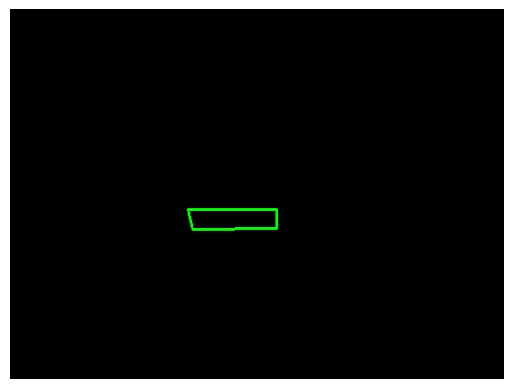

In [300]:
license = lpr.get_lowest_candidate(rectangular_contours)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , [license], -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

## LECTURA DE PLACA

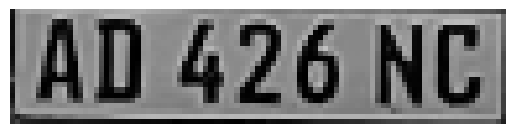

In [302]:
cropped = lpr.crop_license_plate(gray, license)
cropped2 = lpr.crop_license_plate(img, license)
plot_image(cropped, False)

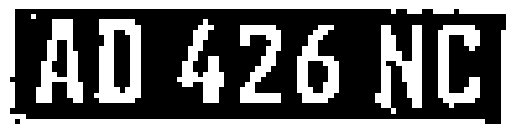

In [303]:
thresh_cropped = lpr.apply_adaptive_threshold(cropped)
plot_image(thresh_cropped)

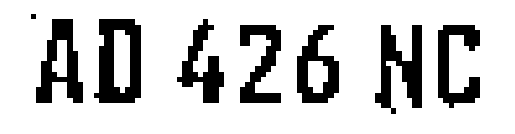

In [304]:
clear_border = lpr.clear_border(thresh_cropped)
final = lpr.invert_image(clear_border)
plot_image(final)

In [305]:
psm = 7
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
#options += " --psm {}".format(psm)
options = "-c tessedit_char_whitelist={} --psm {} --oem 3".format(alphanumeric, psm)
txt = pytesseract.image_to_string(final, config=options)
print(txt[:2], txt[2:5], txt[5:])

AD 426 NC

